In [2]:
#Cleanup Telemetry File from &lt; and &gt; occurencies

dirty_telemetry_csv = "SnS-Telemetry.csv"
clean_telemetry_csv = "SnS-Telemetry-Clean.csv"

breaking_words_list = ["&lt;", "&gt;"]
with open(dirty_telemetry_csv) as dirty, open(clean_telemetry_csv, "w+") as clean:
    for line in dirty:
        for breaking_word in breaking_words_list:
            line = line.replace(breaking_word, " - ")
        clean.write(line)

In [3]:
def add_jumps_row(df):
    actions = 0
    df['Jump'] = 0
    for row in df.itertuples(index = True):
        name = row.Name
        if(name == "TrackStats"):
            df.at[row[0],'Jump'] = actions
            actions = 0
        elif(name == "Jump"):
            actions+=1 

def add_playerItem_row(df):
    actions = 0
    df['PlayerItem'] = 0
    for row in df.itertuples(index = True):
        name = row.Name
        if(name == "TrackStats"):
            df.at[row[0],'PlayerItem'] = actions
            actions = 0
        elif(name == "PlayerItem"):
            actions+=1 

def add_ruleDevice_row(df):
    actions = 0
    df['RuleDevice'] = 0
    for row in df.itertuples(index = True):
        name = row.Name
        if(name == "TrackStats"):
            df.at[row[0],'RuleDevice'] = actions
            actions = 0
        elif(name == "RuleDevice"):
            actions+=1 



In [4]:
#Full Telemetry Overview

import pandas as pd

full_telemetry = pd.read_csv('SnS-Telemetry-Clean.csv', sep=";", decimal=",", skipinitialspace = True, quotechar = '"' )
print(full_telemetry.memory_usage(deep=True))
full_telemetry.dtypes


Index                   128
User_id             1302399
Class               1314517
ServerTime          1571148
Iteraction          1306268
Name                1413007
Piece               1099567
Target               714734
Coordinates(cd1)    1696837
Timestamp(cd2)       165384
dtype: int64


User_id              object
Class                object
ServerTime           object
Iteraction           object
Name                 object
Piece                object
Target               object
Coordinates(cd1)     object
Timestamp(cd2)      float64
dtype: object

In [5]:
#Simple Data Extraction example

infiltration_end_stats = full_telemetry[(full_telemetry.Piece == "Get out alive (return to your bike)") | (full_telemetry["Name"] == "PlayerIsDead")]

#infiltration_end_stats

In [6]:
#outcome extraction

def extract_outcome(row):
    if row['Name'] == 'PlayerIsDead':
        return 'Died'
    if row['Piece'] == 'Get out alive (return to your bike)':
        return 'Won'
    return 'N/A'

infiltration_with_outcome = infiltration_end_stats
infiltration_with_outcome['Outcome'] = infiltration_end_stats.apply(lambda row: extract_outcome(row), axis=1)

#infiltration_with_outcome
#infiltration_with_outcome.iloc[1]


C:\ProgramData\Anaconda3\envs\SNSENV\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
#outcome + class visualization

from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(figsize=(10, 10))

#mosaic(infiltration_end_stats, ['Class','Outcome'], ax=axes )
#print(len(infiltration_end_stats[infiltration_end_stats['Class'] == "COMMANDO"]))

In [8]:
#function for finding out if the goal is the safe or the starting position. 

def extract_goal(df,index):
    if(df.at[index,'Timestamp(cd2)']<10): return
    if(df.at[index-1,'SafeGoal'] ==True):
        if(df.at[index,'Piece'] == "Find and loot The Safe"):
            df.at[index,'SafeGoal'] = False
    else:
        df.at[index,'SafeGoal'] = False
def add_goal_row(dataframe):
    dataframe['SafeGoal'] = True
    dataframe.apply(lambda row: extract_goal(dataframe,row.name),axis=1)
#iterrows etc


In [9]:
#Destroyed object function. how many times were objects destroyed between TrackStats. Resets on the call after TrackStats.

def extract_object_destroyed(df,index):
    if(index == 0):
        df.at[index,'ObjDestroyed'] = 0
        return
    
    if(df.at[index-1,'Name'] == "TrackStats"):
        df.at[index,'ObjDestroyed'] = 0
        return
    else:
        df.at[index,'ObjDestroyed'] = df.at[index-1,'ObjDestroyed']   
    
    if(df.at[index,'Name'] == "ObjectDestroyed"):
        df.at[index,'ObjDestroyed'] +=1
        return
    return

def add_object_destroyed_row(dataframe):
    dataframe['ObjDestroyed'] = 0
    dataframe.apply(lambda row: extract_object_destroyed(dataframe,row.name),axis = 1)
    
#test = basic_stats
#add_object_destroyed_row(test)
#test[(test['ObjDestroyed'] >0) & (test['Name'] == "TrackStats")]

In [10]:
#Destroyed enemy function. how many times enemies were destroyed between TrackStats. Resets on the call after TrackStats

def extract_enemy_destroyed(df,index):
    if(index == 0):
        df.at[index,'EnemyDestroyed'] = 0
        return
    
    if(df.at[index-1,'Name'] == "TrackStats"):
        df.at[index,'EnemyDestroyed'] = 0
        return
    else:
        df.at[index,'EnemyDestroyed'] = df.at[index-1,'EnemyDestroyed']  
        
    if(df.at[index,'Name'] == "Destroyed"):
        df.at[index,'EnemyDestroyed'] +=1
        return
    return

def add_enemy_destroyed_row(dataframe):
    dataframe['EnemyDestroyed'] = 0
    dataframe.apply(lambda row: extract_enemy_destroyed(dataframe,row.name),axis = 1)
    
#test = basic_stats
#add_enemy_destroyed_row(test)
#test[(test['EnemyDestroyed'] >0) & (test['Name'] == "TrackStats")]

In [11]:
#Health lost count function. Checks how many times health was lost between TrackStats. Resets on the call after TrackStats
#FreezeStart seems to be called every call before the player gains health for whatever reason, so checking 
#if that was the last call. Maybe error prone but easy way to get fairly accurate results.

def extract_health_lost(df,index):
    if(index == 0):
        df.at[index,'HealthLostCount'] = 0
        return
    
    if(df.at[index-1,'Name'] == "TrackStats"):
        df.at[index,'HealthLostCount'] = 0
        return
    
    else:
        df.at[index,'HealthLostCount'] = df.at[index-1,'HealthLostCount']
        
    if(df.at[index,'Name'] == "HealthChanged"):
        if(df.at[index-1,'Name'] != "FreezeStart"):
            df.at[index,'HealthLostCount'] +=1
            return
        return

def add_health_lost_row(dataframe):
    dataframe['HealthLostCount'] = 0
    dataframe.apply(lambda row:  extract_health_lost(dataframe,row.name), axis=1)
    
#test = basic_stats
#add_health_lost_row(test)
#test[(test['HealthLostCount'] >0) & (test['Name'] == "TrackStats")]

In [12]:
#coordinate points extraction functions

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def coordinate_to_point(coordinate,index):
      if type(coordinate) != str:
            return None
      coordinate = coordinate.replace(",", ".")
      coordinate = coordinate.split('|')[:3]
      if (len(coordinate) <3):
            return None
      #a,b,c = coordinate
      if(not is_number(coordinate[1])):
        coordinate[1]=0;
      return float(coordinate[index])

def extract_point_single(row,index):
    return coordinate_to_point(row["Coordinates(cd1)"],index)

def coordinate_to_point_all(index,dataframe):
      coordinate = dataframe.at[index,"Coordinates(cd1)"]
      if type(coordinate) != str:
            return None
      coordinate = coordinate.replace(",", ".")
      coordinate = coordinate.split('|')[:3]
      if (len(coordinate) <3):
            coordinate = [None,None,None]
      if(not is_number(coordinate[1]) or float(coordinate[1]) < 0.0001):
        coordinate[1]=0
      dataframe.at[index,'X'] = float(coordinate[0])
      dataframe.at[index,'Y'] = float(coordinate[1])
      dataframe.at[index,'Z'] = float(coordinate[2])

#use to add rows to dataframe
def add_position_rows(dataframe):
    dataframe['X'] =None
    dataframe['Y'] =None
    dataframe['Z'] =None
    dataframe.apply(lambda row:  coordinate_to_point_all(row.name,dataframe), axis=1)
    
    
    

In [13]:
#velocity extraction functions. Currently interval is determined by the distance between consecutive timestamps.
#checks if safegoal was completed, since swapping goal changes distance. Sends a 0 value for distance at that point

def velocityToGoal(index,dataframe):
    if(index>0):
        if(dataframe.at[index,'User_id'] == dataframe.at[index-1,'User_id']):
            if(dataframe.at[index-1,'SafeGoal']== 1 and dataframe.at[index,'SafeGoal'] == 0):
                return 0
            interval = dataframe.at[index,'Timestamp(cd2)'] - dataframe.at[index-1,'Timestamp(cd2)']
            if(interval <1):
                interval = 1
            vel = (dataframe.at[index-1,'distance'] - dataframe.at[index,'distance'] ) / interval
            return(vel)
    return 0
            
    #print(dataframe.index[index])
def add_velocity_to_goal_row(dataframe):
    dataframe['velocityToGoal'] = dataframe.apply(lambda row:  velocityToGoal(row.name,dataframe), axis=1)

In [14]:
#Vertical movement extraction functions. Currently returns vertical movement from the last TrackStats aka 5 seconds

def vertical_movement(index,dataframe):
    if(index>0):
        if(dataframe['User_id'][index] == dataframe['User_id'][index-1]):
            YD = (dataframe['Y'][index] - dataframe['Y'][index-1])
            return(YD)
    return 0
def add_vertical_movement_row(dataframe):
     dataframe['verticalMovement'] = dataframe.apply(lambda row: vertical_movement(row.name,dataframe), axis=1)

In [15]:
#distance extraction functions
#currently requires dataframe to have X, Y and Z components. could make it measure the distance in this function instead 
#also requires SafeGoal column to know what the player's goal is.
#goal coordinates approximately 18,79726|7,179175|-27,15814
#start coordinates approximately -43,5|0,126|100,35

import math
goal = [18.797,7.179,-27.158]
start = [-43.5,0.126,100.35]
def distanceToPoint(A,B):
    XD = B[0] - A[0]
    YD = B[1] - A[1] 
    ZD = B[2] - A[2]
    D = math.sqrt((XD*XD) + (YD*YD) + (ZD*ZD))
    return D

def extract_distance(row):
        if(not row['X']):
            return None
        if(row['SafeGoal']):
            return distanceToPoint([row['X'],row['Y'],row['Z']],[18.797,7.179,-27.158])#goal
        return distanceToPoint([row['X'],row['Y'],row['Z']],[-43.5,0.126,100.35])#start
def add_distance_row(dataframe):
    dataframe['distance'] = dataframe.apply(lambda row:  extract_distance(row), axis=1)

print(distanceToPoint(goal,start))
    

142.0878287609463


In [16]:
def data_clean_up(df):
    df = df[ df["Name"] == "TrackStats"]
    df =df.drop('Name', 1)
    df = df.drop("Piece",1)
    #need to drop null timestamps since we use the timestamps in the functions.
    count = df['Timestamp(cd2)'].isna().sum()
    print("There were " + str(count) + " timestamp nulls")
    df =df.dropna(subset=["Timestamp(cd2)"])
    df.index = range(0,len(df.index))
    return df

There were 97 timestamp nulls
968
715


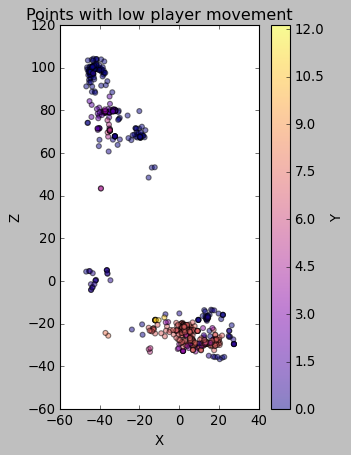

In [17]:
#extraction function idea: how long the player stayed previously in an x*y*z area. either a precomputed grid for the area the player can move in or an area that slowly lerps towards the player. (so if the player moves sufficiently fast they will move out of the grid)
#i'll try the 2nd approach. currently uses a circle with a radius of 5 which moves towards the player at a speed of 0.3x the distance to the player. e.g. distance to player is 20, traveling 0.3 * 20 = 6 units towards the player

#Cylinder class, a circle is used for x and z coordinates. y coordinate is a value cut off
class Cylinder:
    center_x = center_z = center_y = 0
    y_dist = 1
    radius = 5
    def __init__(self, radius,y_dist,x,y,z):
        self.radius = radius
        self.y_dist = y_dist
        self.center_x = x
        self.center_y = y
        self.center_z = z
    def overlap_circular(self,x,z):
        return ( (math.pow(x - self.center_x, 2) + math.pow(z - self.center_z,2)) <= (self.radius*self.radius))
    def overlap_depth(self,y):
        return abs(self.center_y - y) <= self.y_dist
    def overlap(self,x,y,z):
        return (self.overlap_circular(x,z) and self.overlap_depth(y))
    def set_pos(self,x,y,z):
        self.center_x = x
        self.center_y = y
        self.center_z = z

def lerp(v0, v1, t): 
    return (1 - t) * v0 + t * v1

def add_area_time_row(df,percentage):
    pos=[0,0,0]
    time_to_interpolate = 20
    timer = 0
    playerPos = [0,0,0]
    df['areaTime'] = 0
    curTime = 0
    prevStamp = 0

    area_pos = Cylinder(5,1.5,0,0,0)

    for row in df.itertuples(index = True):
        if(df.at[row[0],'Timestamp(cd2)'] <6):
            area_pos.set_pos(-43.5,0.126,100.35)
            prevStamp = 0
            curTime = 0
        #if(row['Name'] != "TrackStats"):
            #continue
        playerPos = [df.at[row[0],'X'],df.at[row[0],'Y'],df.at[row[0],'Z']]

        #moves towards playerPos by x percentage of the difference between the positions. alternatively position moving by just snapping it to the previous trackstats position. not sure which method makes more sense.
        area_pos.set_pos(lerp(area_pos.center_x,playerPos[0],percentage),
                                lerp(area_pos.center_y,playerPos[1],percentage),
                                lerp(area_pos.center_z,playerPos[2],percentage))
        
        if(area_pos.overlap(playerPos[0],playerPos[1],playerPos[2])):
            curTime+=df.at[row[0],'Timestamp(cd2)']-prevStamp
            df.at[row[0],'areaTime'] = curTime
        else:
            curTime = 0
        prevStamp = df.at[row[0],'Timestamp(cd2)']
    

dat = full_telemetry[["User_id","Class","Coordinates(cd1)","Timestamp(cd2)","Name","Piece"]]
dat = data_clean_up(dat)
add_position_rows(dat)
dat =dat.dropna(subset=["X"])
add_area_time_row(dat,0.3)
print(len(dat[dat['areaTime']>0]))
print(len(dat.loc[(dat['areaTime']>0) & (dat['X'] > -40 )] ))

#dat = dat.loc[(dat['areaTime']>9) & (dat['Name'] == "TrackStats" )]

dat =   dat.loc[(dat['areaTime']>7)]
fig = plt.figure(figsize=(4, 6), dpi=80)
plt.scatter(dat['X'],dat['Z'], s=20,c = dat['Y'],alpha=0.5,cmap="plasma")
plt.colorbar(label = "Y")
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Points with low player movement")
plt.show()

There were 97 timestamp nulls
Largest number of areas on a playthrough was 33


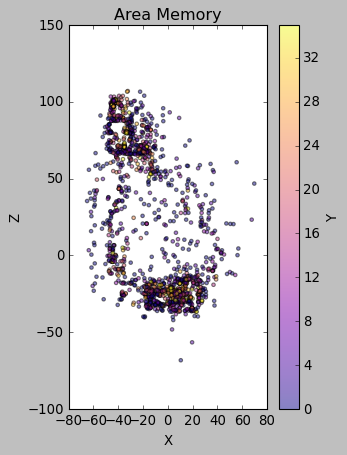

In [18]:
#keeps track of the map as the player traverses the level and keeps track of the time player spent in each area. currently areas are of size 20*20
#doesn't take into account player's y value for a few reasons: less computation and easier implementation. it could produce some bias in e.g. buildings though, where the player is arguably in "new" areas but same x and z positions
#also currently loops through all cells, could e.g. store cell locations in a hashmap and access them based on the rounded coordinates if it gets too slow   
class Cell:
    cell_size_x = 0
    cell_size_z = 0
    cell_center_x = 0
    cell_center_z = 0
    timeSpent = 0
    def __init__(self, c_x = 0,c_z = 0 , s_x = 10,s_z = 10):
        self.cell_size_x = s_x
        self.cell_size_z = s_z
        self.cell_center_x = c_x
        self.cell_center_z = c_z
        self.timeSpent = 0
    def set_pos(self,x,z):
        self.cell_center_z = Z
        self.cell_center_z = x
    def overlap(self,x,z):
        xmax = self.cell_center_x + self.cell_size_x
        xmin = self.cell_center_x  - self.cell_size_x
        zmax = self.cell_center_z + self.cell_size_z
        zmin = self.cell_center_z  - self.cell_size_z
        overlaps = (xmin<=x<=xmax and zmin<=z<=zmax)
        if(overlaps):
            self.timeSpent = self.timeSpent + 5
            return True
        return False

def myround(x, base=20):
    return base * round(x/base)

def round_down(x, base = 20):
    return base * math.floor(x/base)

def round_up(x, base = 20):
    return base * math.ceil(x/base)

class Area:
    cells = []
    def add_cell(self,c_x = 0, c_z = 0):
        self.cells.append(Cell(c_x,c_z))
    def check_overlap(self,x,z):
        min_dist = 15555
        x_dif = 0
        z_dif = 0
        cell_x = 0
        cell_z = 0
        for cell in self.cells:
            if(cell.overlap(x,z)):
                return cell.timeSpent
            dist = math.sqrt( ( x-cell.cell_center_x) * ( x-  cell.cell_center_x) + ( z - cell.cell_center_z) * ( z - cell.cell_center_z) )
            if(dist < min_dist):
                cell_x = cell.cell_center_x
                cell_z = cell.cell_center_z
                x_dif = x -  cell_x
                z_dif = z - cell_z
                min_dist = dist
        
        #rounding down cell position based on distance from the cell with minimum distance from the current cell. currently uses an interval of 20, all the cells are evenly spaced apart.
        rounded_x = x_dif + cell_x
        rounded_z = z_dif + cell_z
        if(x_dif > 10 or x_dif < -10 or z_dif >10 or z_dif < -10):
            rounded_x = myround(rounded_x)
            rounded_z = myround(rounded_z)
        else:
            rounded_x = cell_x
            rounded_z = cell_z
        #print("creating new cell at " + str(rounded_x) + " and " + str(rounded_z))
        self.add_cell(rounded_x,rounded_z)
        return 0
    def clear_area(self):
        self.cells = []
#t = Area()
#t.add_cell(5,0)
#print(len(t.cells))
#print("overlap time " + str(t.check_overlap(16,0)))
#print("overlap time " + str(t.check_overlap(12.5,0)))
##for c in t.cells:
    #print (str(c.cell_center_x) + "and"  + str(c.cell_center_z))
def add_area_memory_row(df):
    #currently rounds areas by area size and doesn't allow for offsets, so not setting exact coordinate for first area.
    start = [-40,100]
    area = Area()
    area.add_cell(start[0],start[1])    
    playerPos = [0,0]
    df['areaMemory'] = 0
    largest_area = 0
    for row in df.itertuples(index = True):
        if(df.at[row[0],'Timestamp(cd2)'] <6):
            largest_area = max(largest_area,len(area.cells))
            area.clear_area()
            area.add_cell(start[0],start[1])   
        playerPos = [ df.at[row[0],'X'], df.at[row[0],'Z']]
        time_visited = area.check_overlap(playerPos[0],playerPos[1])
        df.at[row[0],'areaMemory'] = time_visited
    print("Largest number of areas on a playthrough was " + str(largest_area))
        
basic_stats = full_telemetry[["User_id","Class","Coordinates(cd1)","Timestamp(cd2)","Name","Piece"]]
basic_stats = data_clean_up(basic_stats)
add_position_rows(basic_stats)
add_area_memory_row(basic_stats)

basic_stats=   basic_stats.loc[(basic_stats['areaMemory']<40)]
fig = plt.figure(figsize=(4, 6), dpi=80)
plt.scatter(basic_stats['X'],basic_stats['Z'], s=10,c = basic_stats['areaMemory'],alpha=0.5,cmap="plasma")
plt.colorbar(label = "Y")
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Area Memory")
plt.show()

In [19]:
#number of meaningful actions : meaningful actions are actions that the player can take that influence the gameworld or the player's state in a meaningful way
#maybe movement, open inventory, WeaponFire, CrouchStart?, GadgetOn, AbilityOn, maybe both?, playeritem,    


def add_actions_row(df):
    actions = 0
    df['action_count'] = 0
    for row in basic_stats.itertuples(index = True):
        name = row.Name
        if(name == "TrackStats"):
            df.at[row[0],'action_count'] = actions
            actions = 0
        elif(name == "WeaponFire" or name == "PlayerInventory" or name == "PlayerItem" or name == "AbilityOn" or name == "VaultLow" or name == "VaultHigh" or name == "CrouchStart" or name == "HackingStart" or name == "ClimbingStart" or name == "WeaponReload" or name == "RuleDevice"):
            actions+=1

def extract_actions(df,index):
    incr = 0
    if(index==0):
        return
    name = df.at[index,'Name']
    if(name == "WeaponFire" or name == "PlayerInventory" or name == "PlayerItem" or name == "AbilityOn" or name == "VaultLow" or name == "VaultHigh" or name == "CrouchStart" or name == "HackingStart" or name == "ClimbingStart" or name == "WeaponReload" or name == "RuleDevice"):
        incr = 1
    if(df.at[index-1,'Name'] == "TrackStats"):
        df.at[index,'action_count'] = incr
    else:
        df.at[index,'action_count'] = df.at[index-1,'action_count'] + incr


def add_actions_row_old(dataframe):
    dataframe['action_count'] = 0
    dataframe.apply(lambda row:  extract_actions(dataframe,row.name), axis=1)




In [20]:
#Basic stats used to extract new features. Features needed for extra feature extraction are kept in the start.

basic_stats = full_telemetry[["User_id","Class","Coordinates(cd1)","Timestamp(cd2)","Name","Piece"]]

#currently csv file is sorted by ServerTime instead of User_id for some reason, so we need to sort it by User_id and timestamp. otherwise user_ids are sometimes mixed up together.
basic_stats = basic_stats.sort_values(["User_id", "Timestamp(cd2)"], ascending = (True, True))

#basic_stats = basic_stats[ (basic_stats['User_id'] != '08be97') & (basic_stats['User_id'] != '09bda8') &(basic_stats['User_id'] != '446596') & (basic_stats['User_id'] != '9b1403') &(basic_stats['User_id'] != 'bd1c89') & (basic_stats['User_id'] != 'ca8613') &(basic_stats['User_id'] != 'e6afd1')  & (basic_stats['User_id'] != 'ee5b75')& (basic_stats['User_id'] != 'f31525') ] 
basic_stats.index = range(0,len(basic_stats.index))

basic_stats['User_id'].nunique() #test['HealthLostCount'] >0) & (test['Name'] == "TrackStats")]
print(len(basic_stats))


20673


In [21]:
#pre clean-up extraction. When we need rows other than the rows kept in the end. e.g. only the TrackStats are kept after cleanup.
import time
start = time.time()
#display(basic_stats.loc[(basic_stats['User_id'] == 'b24229') & (basic_stats['Timestamp(cd2)'] > 550)])
add_goal_row(basic_stats)
#display(basic_stats.loc[(basic_stats['User_id'] == 'b24229') & (basic_stats['Timestamp(cd2)'] > 550)])
add_enemy_destroyed_row(basic_stats)
add_object_destroyed_row(basic_stats)
add_health_lost_row(basic_stats)
add_actions_row(basic_stats)    
end = time.time()

add_jumps_row(basic_stats)
add_playerItem_row(basic_stats)
add_ruleDevice_row(basic_stats)

#display(basic_stats.head(500))
basic_stats[basic_stats['Jump']>0]#.tail(20)

#display(basic_stats)


,User_id,Class,Coordinates(cd1),Timestamp(cd2),Name,Piece,SafeGoal,EnemyDestroyed,ObjDestroyed,HealthLostCount,action_count,Jump,PlayerItem,RuleDevice
312,039d59,COMMANDO,-35.05377|0.4685311|4.592561,195.0,TrackStats,NaN,True,0,0,0,0,1,0,0
320,039d59,COMMANDO,-43.39627|1.162196|6.644109,205.0,TrackStats,NaN,True,0,0,0,0,1,0,0
1550,08be97,COMMANDO,NaN,NaN,TrackStats,NaN,False,0,0,0,0,1,0,0
1566,08be97,COMMANDO,NaN,NaN,TrackStats,NaN,False,0,0,0,1,1,0,0
1718,09bda8,HACKER,29.888|-2.384186E-07|-21.68637,120.0,TrackStats,NaN,True,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19365,ee5b75,NINJA,"33,23986|4,255164|29,3461",60.0,TrackStats,NaN,True,0,0,0,1,1,0,0
19603,ee5b75,NINJA,"-18,13846|8,550961|-25,03075",366.0,TrackStats,NaN,False,0,0,0,0,1,0,0
19619,ee5b75,NINJA,"-58,92279|-3,576279E-07|-5,214823",381.0,TrackStats,NaN,False,0,0,0,1,1,0,0
19973,f31525,COMMANDO,"28,37912|-5,960464E-08|-22,65356",254.0,TrackStats,NaN,True,0,0,0,0,1,0,0


In [22]:
basic_stats = basic_stats.sort_values(["User_id", "Timestamp(cd2)"], ascending = (True, True))
basic_stats = data_clean_up(basic_stats)

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

There were 97 timestamp nulls


In [23]:
#post clean-up extraction
start = time.time()
basic_stats.index = range(0,len(basic_stats.index))
add_position_rows(basic_stats)
add_area_time_row(basic_stats,0.3)
add_area_memory_row(basic_stats)
add_distance_row(basic_stats)
#needs distance row
add_velocity_to_goal_row(basic_stats)
print("fastest movement speed was " + str(basic_stats['velocityToGoal'].max()) + " during trackstats intervals ")
add_vertical_movement_row(basic_stats)

Largest number of areas on a playthrough was 33
fastest movement speed was 4.971453370261591 during trackstats intervals 


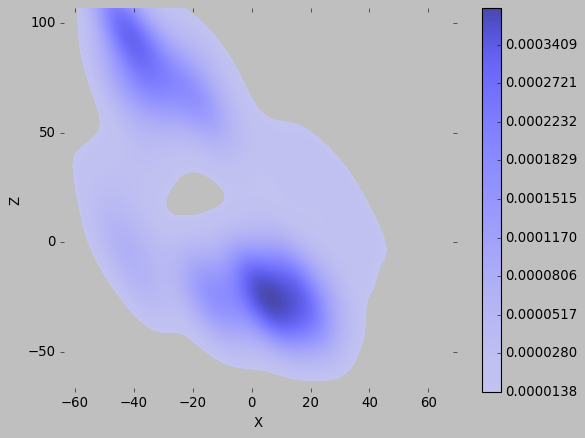

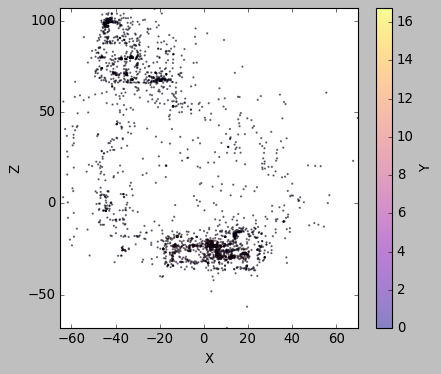

C:\ProgramData\Anaconda3\envs\SNSENV\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


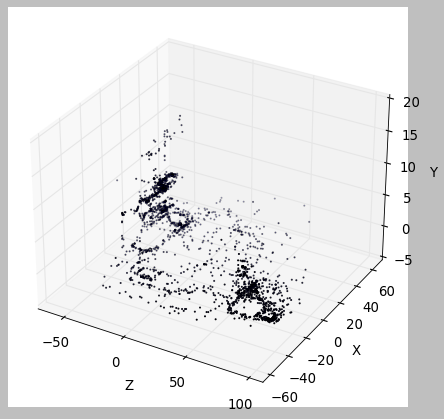

In [24]:


#player position visualization

import seaborn as sns
import numpy as np 
#from scipy.ndimage.filters import gaussian_filter
#import matplotlib.colors as colors

new = basic_stats[['X', 'Y','Z']].copy().dropna()
xmin = new['X'].min()
xmax = new['X'].max()
zmin = new['Z'].min()
zmax = new['Z'].max()

#kdeplot
#parameters = x, y, kernel="gau", bw = 25, cmap="Reds", n_levels = 50, shade=True, shade_lowest=False, gridsize=100
data = new[['X','Z']]
ax = sns.kdeplot(x = new['X'],y= new['Z'],
                 shade=True,n_levels = 200,vmax=0.00045,cbar = True)
ax.set_frame_on(False)
plt.xlim(xmin, xmax)
plt.ylim(zmin, zmax)
plt.show()

#scatterplot
fig = plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(new['X'],new['Z'], s=1,c = new['Y'],alpha=0.5,cmap="plasma")
plt.colorbar(label = "Y")
plt.xlabel("X")
plt.ylabel("Z")
plt.xlim(xmin, xmax)
plt.ylim(zmin, zmax)
plt.show()

#3d scatterplot
from mpl_toolkits.mplot3d import Axes3D
import random

#3d plot
fig = plt.figure(figsize=(6, 5), dpi=80)
ax = Axes3D(fig)
ax.scatter(new['Z'], new['X'], new['Y'],s=0.7)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.ylim(xmin, xmax)
plt.xlim(zmin, zmax)
plt.show()


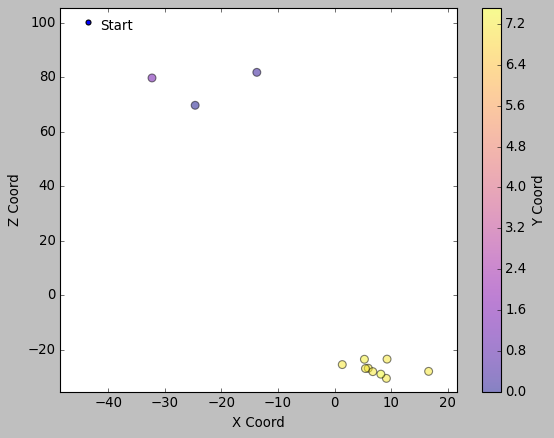

In [25]:
#player death position visualization

import warnings
warnings.filterwarnings("ignore")
start = [-43.5,0.126,100.35]
loss = infiltration_with_outcome
#loss.loc[loss['Outcome'] == "Died"]
loss = loss[loss['Outcome'] == "Died"]
add_position_rows(loss)
loss[['Outcome','X', 'Y','Z']].dropna()

#scatterplot
plt.scatter(loss['X'],loss['Z'], s=50,c = loss['Y'],alpha=0.5,cmap="plasma")
plt.colorbar(label = "Y Coord")
plt.xlabel("X Coord")
plt.ylabel("Z Coord")
plt.xlim(start[0]-5, loss['X'].max()+5)
plt.ylim(loss['Z'].min()-5, start[2]+5)
plt.scatter(start[0],start[2])
plt.annotate("Start", (start[0]+2,start[2]-3))
plt.show()

In [26]:
def get_data_by_id(df,id):
    temp = df.copy()
    temp = temp[temp["User_id"] == id]
    temp.index = range(0,len(temp.index))
    return temp

#currently flow marked every 5 seconds
#low flow = player seems bored/frustrated/confused. actions don't contribute to a goal.
#high flow = player is engaged and their actions have intent
#flow of AP_d2ddf4 aka a62e46
flow_d2ddf4 = pd.DataFrame({
    'flow':[0.4,0.3,0.8,1,1,0.9,1,1,0.9,0.8,0.9,1,1,1,1,1,0.7,1,0.5,0.9,1,1,0.7,0.9,1,0.8,1,0.9,0.4,0.9,1,0.7,1,0.6,0.8,1,1,1,1,0.4,0.6,0.4,0.2,0.8,1,0.8,1,1,1,1,1,1,1,1,1,1,1,1]
})

#too many null values for timestamp and coordinate. Also time between trackstats is often not 5 seconds. so using the data is mostly impossible, partly because the data is created with the 5 second gap in mind. 
#had around 40 rows with null values with timestamp, also coordinates often, so most of the flow_data is unusable either way since we can't calculate features.
#flow of User_id = "f31525"
flow_f31525 = pd.DataFrame({
    'flow': [0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.2, 0.2, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.5, 0.7, 0.5, 0.5, 0.4, 0.4, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.7, 0.8, 0.7, 0.7, 0.6, 0.6, 0.6, 0.7, 0.7, 0.5, 0.5, 0.7, 0.6, 0.5, 0.6, 0.5, 0.4, 0.4, 0.6, 0.6, 0.6, 0.7, 0.7]
}) 

#flow of User_id = 4688bb
flow_4688bb =pd.DataFrame({
    'flow': [0.3 ,0.6 ,0.7 ,0.4 ,0.4 ,0.6 ,0.7 ,0.5 ,0.5 ,0.6 ,0.65,0.5 ,0.5 ,0.5 ,0.6 ,0.6 ,0.7 ,0.5 ,0.6 ,0.5 ,0.4 ,0.35,0.35,0.3 ,0.3 ,0.35,0.5 ,0.6 ,0.6 ,0.8 ,0.6 ,0.4 ,0.4 ,0.5 ,0.65,0.7 ,0.5 ,0.55,0.6 ,0.7 ,0.65,0.7 ,0.6 ,0.5 ,0.3 ,0.5 ,0.6 ,0.5 ,0.4 ,0.3 ,0.35,0.4 ,0.6 ,0.6 ,0.8 ,0.8 ,0.7 ,0.5 ,0.35,0.35,0.35,0.6 ,0.5 ,0.5 ,0.65,0.65,0.5 ,0.6 ,0.7 ,0.5 ,0.5 ,0.5 ,0.4 ,0.3 ,0.3 ,0.3 ,0.3 ,0.2 ,0.2 ,0.2 ,0.4 ,0.6]
}) 

flow_data_d2ddf4 = get_data_by_id(basic_stats,'d2ddf4')
flow_data_4688bb = get_data_by_id(basic_stats,'4688bb')
flow_data_4688bb = pd.concat([flow_data_4688bb,flow_4688bb], axis = 1)
flow_data_d2ddf4 = pd.concat([flow_data_d2ddf4,flow_d2ddf4], axis = 1)

flow_numeric = flow_data_d2ddf4.append(flow_data_4688bb)
flow_numeric.index = range(0,len(flow_numeric.index))

In [27]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - float(min_value)) / (max_value - float(min_value))
    return result

Feature distance: 4.039973
Feature ObjDestroyed: 3.755561
Feature HealthLostCount: 0.344329
Feature EnemyDestroyed: 2.831712
Feature velocityToGoal: 1.323261
Feature verticalMovement: 0.007936
Feature areaTime: 8.209190
Feature action_count: 17.126664
Feature areaMemory: 0.002701


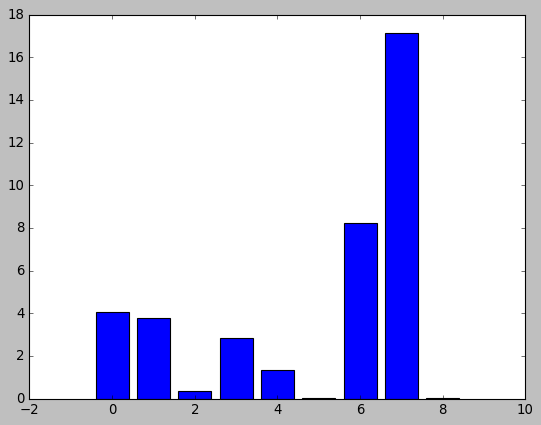

SVR error
0.0689567255813438
[0.62734919 0.84329707 0.72041278 0.92919913 0.78068304 0.86476656
 0.52395209 0.84075568 0.90567432 0.8300004  0.82638496 0.57647233
 0.57462335 0.64253894 0.63839531 0.58551003 0.77675968 0.49706818
 0.63112565 0.61966409 0.62635439 0.61776646 0.80947275 0.47047468
 0.60454475 0.58499032 0.58609755 0.78503162]
8      0.90
91     0.50
121    0.50
110    0.60
27     0.90
102    0.30
61     0.40
97     0.70
114    0.70
122    0.65
26     1.00
90     0.40
24     1.00
111    0.60
92     0.65
60     0.70
136    0.20
51     1.00
120    0.50
107    0.30
33     0.60
22     0.70
2      0.80
119    0.60
63     0.60
18     0.50
10     0.90
54     1.00
Name: flow, dtype: float64
gradient boosting error
0.08001804503119492


array([0.50932831, 0.92387566, 0.79440637, 0.87719447, 0.70386719,
       0.85077827, 0.38635   , 0.88603897, 1.00222796, 1.16308087,
       0.68515066, 0.52347008, 0.82560294, 0.54801002, 0.74602652,
       0.57734769, 0.85198826, 0.66465161, 0.7436347 , 0.67374171,
       0.5105295 , 0.55454268, 0.79593769, 0.43723984, 0.57298251,
       0.49944057, 0.72858099, 0.86088389])

8      0.90
91     0.50
121    0.50
110    0.60
27     0.90
102    0.30
61     0.40
97     0.70
114    0.70
122    0.65
26     1.00
90     0.40
24     1.00
111    0.60
92     0.65
60     0.70
136    0.20
51     1.00
120    0.50
107    0.30
33     0.60
22     0.70
2      0.80
119    0.60
63     0.60
18     0.50
10     0.90
54     1.00
Name: flow, dtype: float64

array([0.20355606, 0.01721375, 0.        , 0.00210854, 0.32833564,
       0.15437363, 0.04907806, 0.15347808, 0.09185624])

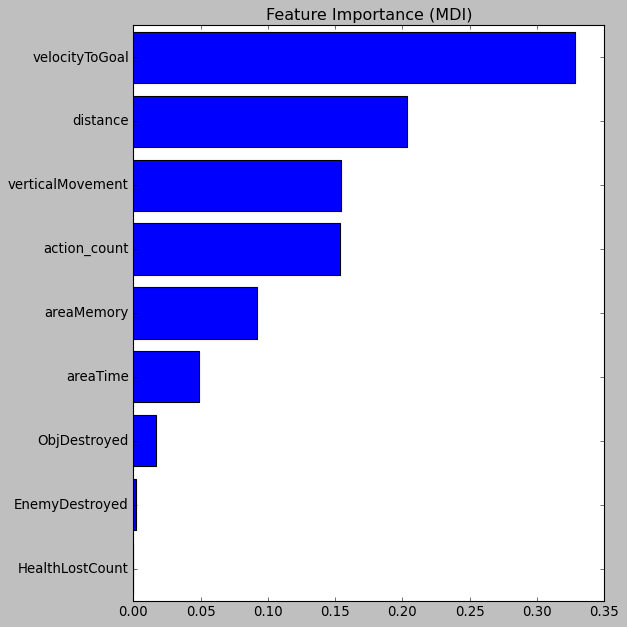

In [28]:
#model training
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

tx = flow_numeric.dropna()
ty = tx['flow']
tx = tx[["distance","ObjDestroyed","HealthLostCount","EnemyDestroyed","velocityToGoal",'verticalMovement','areaTime','action_count','areaMemory']]
xtr,xte, ytr, yte = train_test_split(tx,ty, test_size=0.2, random_state=0)

#if a minmaxscaler/standardizer for the final product is used it needs to be saved for prediction. same with the model naturally.
normalizer = MinMaxScaler()

#xtr =pd.DataFrame(scaler.fit_transform(xtr),columns=xtr.columns)
xtr = pd.DataFrame(normalizer.fit_transform(xtr),columns=xtr.columns)

#xte = pd.DataFrame(scaler.transform(xte),columns=xte.columns)
xte = pd.DataFrame(normalizer.transform(xte),columns=xte.columns)

#initial feature selection with f_regression
cols = xtr.columns
def feature_selection(xtr,ytr,xte):
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(xtr, ytr)
	# transform train input data
	cols = fs.get_support(indices=True)
	xtr_fs = pd.DataFrame(fs.transform(xtr))
	# transform test input data
	xte_fs = fs.transform(xte)
	return xtr_fs,xte_fs,fs,cols

#feature selection

xtr_fs,xte_fs,fs,cols = feature_selection(xtr,ytr,xte)

# Feature scores
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (xtr.columns[cols][i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

#first model testing
#model = MLPRegressor(solver='lbfgs', alpha=1e-4,hidden_layer_sizes=(50,40,30,20,15), random_state=1, max_iter=5000, tol = 1e-5,learning_rate_init=1e-4, n_iter_no_change = 20,max_fun = 30000)
#model = SVR()
from sklearn.neighbors import KNeighborsRegressor

model = SVR()
#model = KNeighborsRegressor()
model.fit(xtr_fs,ytr)
yhat = model.predict(xte_fs)
error = mean_squared_error(yte,yhat)
print("SVR error")
print(error)
print(yhat)
print(yte)

#2nd model testing
model = GradientBoostingRegressor(n_estimators=200)
model.fit(xtr_fs,ytr)
yhat = model.predict(xte_fs)
error = mean_squared_error(yte,yhat)
print("gradient boosting error")
print(error)
display(yhat)
display(yte)
display(model.feature_importances_)

#permutation importance performed on test with gradientboostingregressor
#more accurate for the specific model, since the model is trained and then the features are evaluated based on the model
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xtr.columns[cols])[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(model, xte_fs, yte, n_repeats=3,
                                random_state=5, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()


Accuracy grid search: 52.40
              precision    recall  f1-score   support

    COMMANDO       0.48      0.55      0.51       168
      HACKER       0.58      0.56      0.57       161
       NINJA       0.52      0.44      0.48       129

    accuracy                           0.52       458
   macro avg       0.53      0.52      0.52       458
weighted avg       0.53      0.52      0.52       458


Accuracy: 53.49
              precision    recall  f1-score   support

    COMMANDO       0.49      0.55      0.52       168
      HACKER       0.60      0.56      0.58       161
       NINJA       0.53      0.48      0.50       129

    accuracy                           0.53       458
   macro avg       0.54      0.53      0.53       458
weighted avg       0.54      0.53      0.54       458



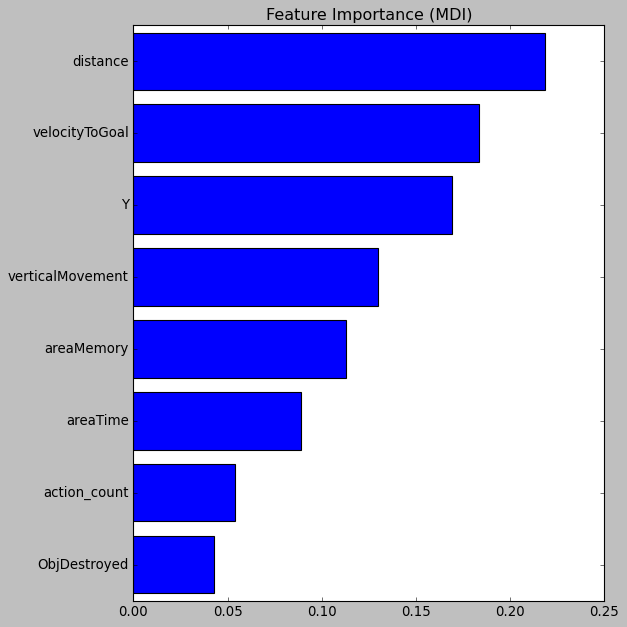

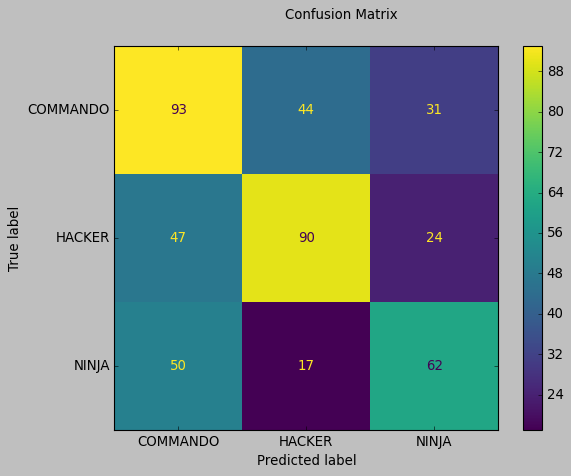

In [29]:
#Class prediction based on features not invented for that just for fun

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
b = basic_stats.dropna()
#removes bias from beginning
#b.drop(index=b[b['Class'] == 'HACKER'].index, inplace=True)

b = b[b['Z']<90]
ty = b['Class']
#print(len(b[b['Class'] == "HACKER"]))
tx = b[["distance","ObjDestroyed","velocityToGoal",'verticalMovement','areaTime','action_count','areaMemory','Y']]
xtr,xte, ytr, yte = train_test_split(tx,ty, test_size=0.2, random_state=39)

def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc
#if a minmaxscaler/standardizer for the final product is used it needs to be saved for prediction. same with the model naturally.

#xtr =pd.DataFrame(scaler.fit_transform(xtr),columns=xtr.columns)
xtr = pd.DataFrame(scaler.fit_transform(xtr),columns=xtr.columns)

#xte = pd.DataFrame(scaler.transform(xte),columns=xte.columns)
xte = pd.DataFrame(scaler.transform(xte),columns=xte.columns)





#parameters to tune
parameters = {
 "n_estimators": [100
 ],
 "learning_rate": [.1,0.05,0.01],
 "max_depth" : [4],
 "min_samples_leaf" :[1],
 "max_leaf_nodes" : [15]
 }
#instantiate the gridsearch
#hgb_grid = GridSearchCV(model, parameters, n_jobs=5, 
 #cv=4, scoring="f1_micro",
 #verbose=2, refit=True)

model = GradientBoostingClassifier(learning_rate=0.05,max_depth=4,max_leaf_nodes = 15, min_samples_leaf = 1)
model.fit(xtr,ytr)
yhat = model.predict(xte)
accuracy = accuracy_score(yte, yhat)
print('\nAccuracy grid search: %.2f' % (accuracy*100))

from sklearn.metrics import classification_report
print(classification_report(yte,yhat))


#2nd model testing
model = GradientBoostingClassifier()
model.fit(xtr,ytr)
yhat = model.predict(xte)
accuracy = accuracy_score(yte, yhat)
print('\nAccuracy: %.2f' % (accuracy*100))

""" print("probabilities vs played class")
prob = model.predict_proba(xte)
p_vs_t = pd.DataFrame(prob,columns=['COMMANDO','HACKER','NINJA'])
p_vs_t.index = range(0,len(p_vs_t.index)) 
yte_temp = pd.DataFrame(yte)
yte_temp.index = range(0,len(yte_temp.index))
p_vs_t['Class'] = yte_temp
the higher the model's confidence, the more likely it is to be correct.
p_vs_t = p_vs_t[(p_vs_t['COMMANDO']>.65) | (p_vs_t['HACKER']> .65) | (p_vs_t['NINJA']> .65) ] """

#print(p_vs_t.head(20))
print(classification_report(yte,yhat))

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(xtr.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(model, xte, yte, n_repeats=3,
                                random_state=5, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

from sklearn.metrics import plot_confusion_matrix
test = plot_confusion_matrix(model,xte,yte)
test.figure_.suptitle("Confusion Matrix")

plt.show()

,cluster_no
cluster_no,
1,2554
2,17
3,11
4,24
5,2


,areaTime,action_count
cluster_no,,
1,6.864526,0.624119
2,4.470588,7.764706
3,195.000000,0.090909
4,116.750000,0.583333
5,2.500000,24.000000


,cluster_no
cluster_no,
1,1610
2,9
3,862
4,124
5,3


,ObjDestroyed,Y
cluster_no,,
1,0.000000,0.227564
2,2.000000,6.565001
3,0.000000,6.450193
4,1.000000,4.104232
5,5.666667,7.220133


,cluster_no
cluster_no,
1,2108
2,8
3,38
4,92
5,10
6,256
7,9
8,8
9,79


,areaTime,velocityToGoal,distance
cluster_no,,,
1,5.396584,0.278026,63.193238
2,162.500000,-0.005432,140.983490
3,52.447368,0.096734,133.340311
4,0.217391,-2.887611,47.584175
5,117.500000,-0.001110,140.934681
6,0.097656,3.396553,54.839894
7,93.222222,0.265051,15.504811
8,202.500000,-0.050708,143.677513
9,53.316456,0.019231,15.256456


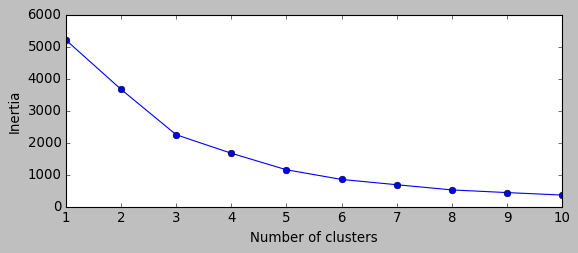

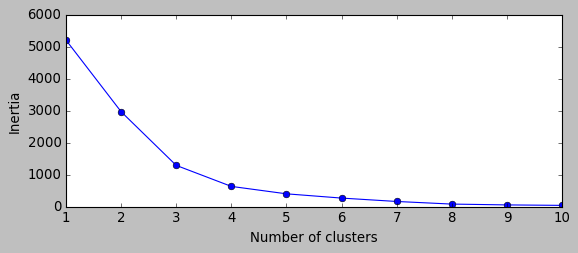

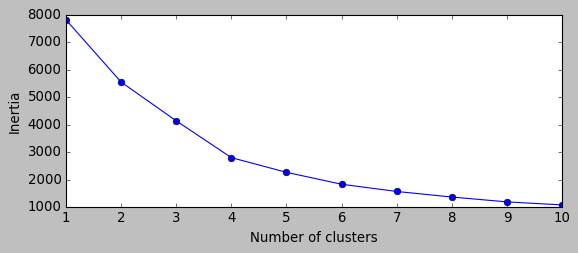

In [30]:
#clustering variables with some clustering algorithms. doesn't really provide much.
from IPython.display import display   
data = basic_stats[["distance","ObjDestroyed","HealthLostCount","EnemyDestroyed","velocityToGoal",'verticalMovement','Y','X','Z','areaTime','areaMemory','action_count']].dropna()
#display(data[data["HealthLostCount"] >3])
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import FeatureAgglomeration
scaler = StandardScaler()
def cluster_data_with_results(data,cluster_count):
    data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
    SSE = []
    for cluster in range(1,11):
        kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
        kmeans.fit(data)
        SSE.append(kmeans.inertia_)

    # plotting different cluster counts to choose cluster count
    frame = pd.DataFrame({'Cluster':range(1,11), 'SSE':SSE})
    plt.figure(figsize=(8,3))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    
    #km= KMeans(n_clusters=cluster_count, random_state=0, init='k-means++')
    km= SpectralClustering(n_clusters=cluster_count, assign_labels='discretize')
   # km = AgglomerativeClustering(n_clusters = cluster_count)
    #km= DBSCAN(eps=0.5, min_samples=5)
    km = km.fit(data)
    #print("inertia")
    #print(km.inertia_)
    clusters = km.labels_
    #inverse scale to understand data
    data = pd.DataFrame(scaler.inverse_transform(data),columns=data.columns)   
    data["cluster_no"] = clusters
    data["cluster_no"] = data["cluster_no"] + 1
    display(data.groupby("cluster_no").agg({"cluster_no": "count"}))
    display(data.groupby("cluster_no").agg(np.mean))
cluster_data_with_results(data[["areaTime","action_count"]],5)
cluster_data_with_results(data[["ObjDestroyed","Y"]],5)
cluster_data_with_results(data[["areaTime","velocityToGoal","distance"]],10)
#cluster_data_with_results(data[["HealthLostCount",'distance']],4)

#cluster_data_with_results(data[["distance","ObjDestroyed","HealthLostCount","EnemyDestroyed","velocityToGoal",'verticalMovement','Y']],7)

[0 0 0 ... 2 2 2]


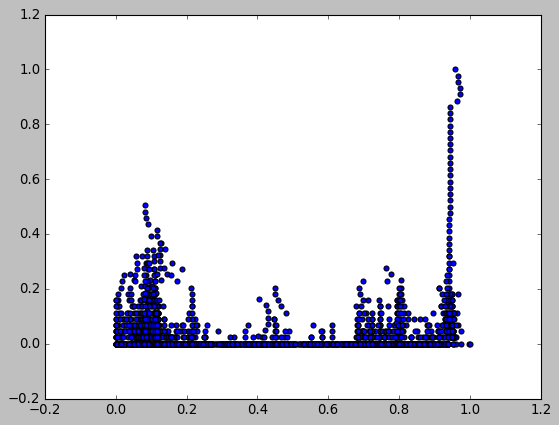

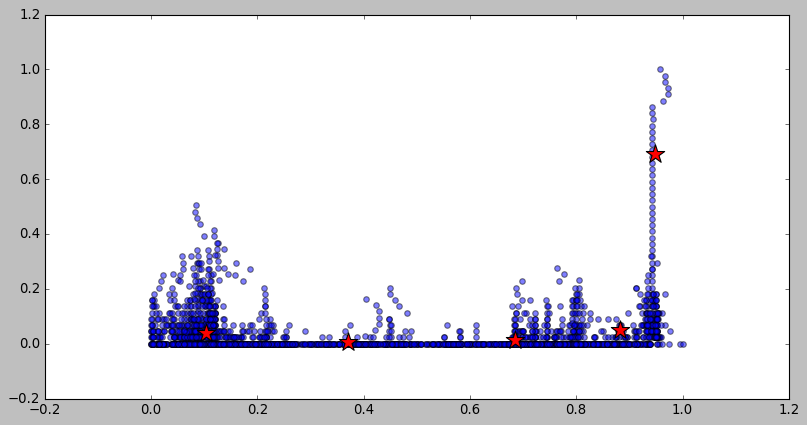

In [31]:
#2 variable plotting
data = normalize(basic_stats[["distance","areaTime"]].dropna())
#kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
plt.scatter(data.iloc[:, 0],data.iloc[:, 1])

km = KMeans(n_clusters=5, max_iter=1000,init='k-means++')
km.fit(data)
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(12, 6))
print(km.labels_)
plt.scatter(data.iloc[:, 0],data.iloc[:, 1],alpha = 0.5, s = 25)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')

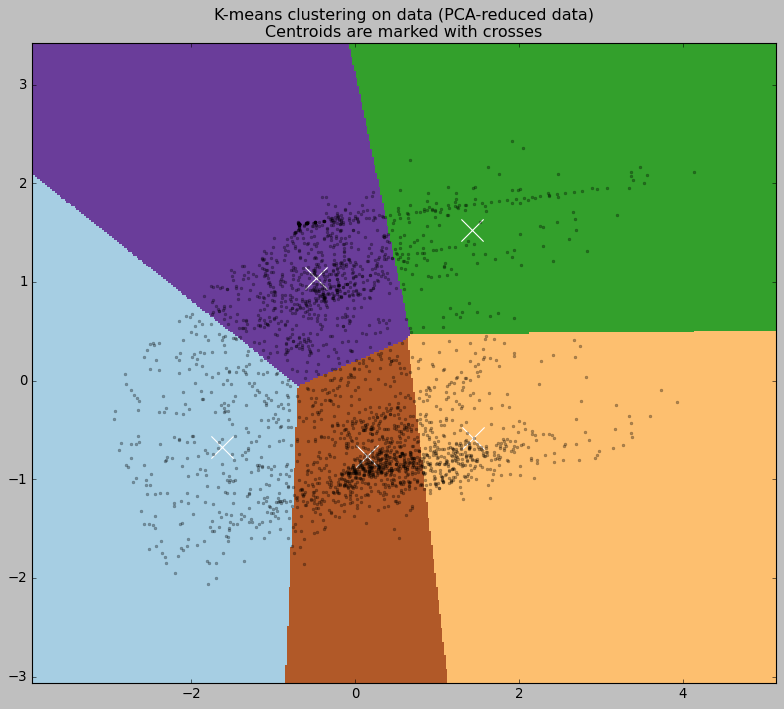

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

data = basic_stats[["distance","velocityToGoal",'areaMemory']].dropna()
data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=5)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02  

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(12, 10))
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5,alpha = 0.3)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=400,
            color="w")
plt.title("K-means clustering on data (PCA-reduced data)\n"
          "Centroids are marked with crosses")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

## 

[Text(0.5, 1.0, 'Hacker Uses Hack'), Text(0.5, 0, '')]

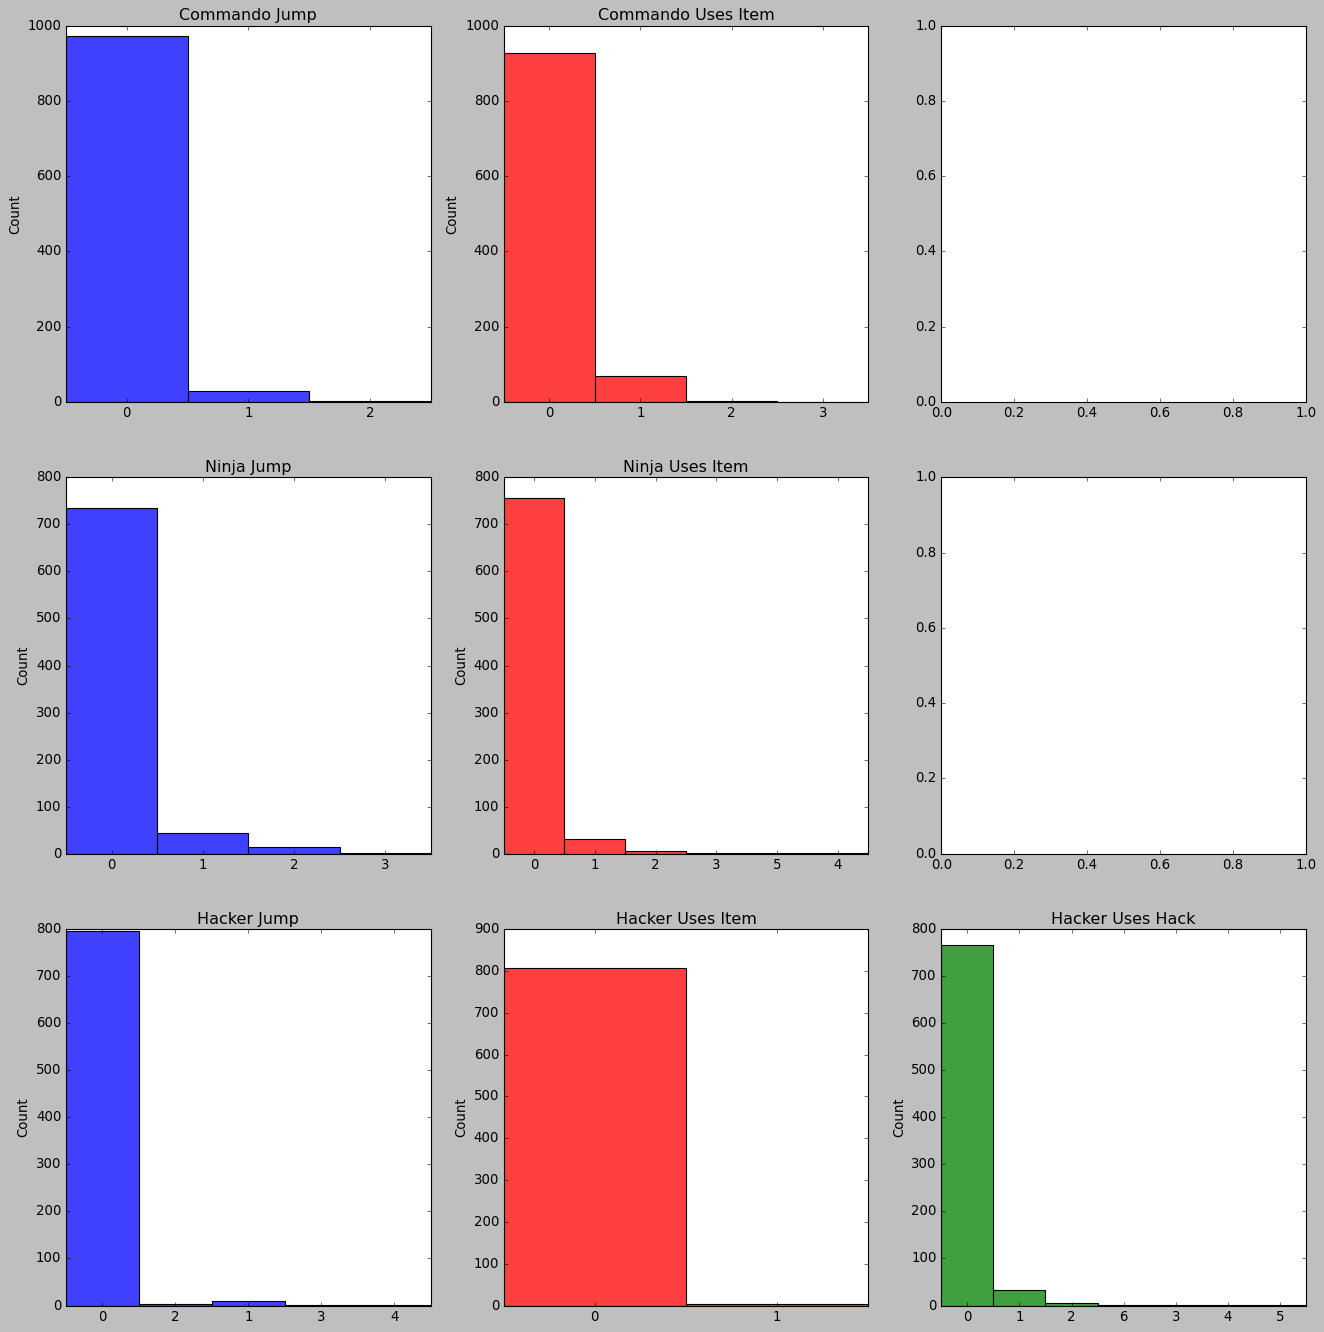

In [35]:
import matplotlib.pyplot as plt

#Plot style that shows low value statistic more clearly
plt.style.use('classic')

#Some basic 
new = basic_stats[['User_id','Jump', 'PlayerItem', 'RuleDevice', 'Timestamp(cd2)','Class']].copy().dropna()
user_id = new['User_id']
timestamp = new['Timestamp(cd2)']
Class = new['Class']

commando = new[new["Class"] == "COMMANDO"].astype(str)
ninja = new[new["Class"] == "NINJA"].astype(str)
hacker = new[new["Class"] == "HACKER"].astype(str)

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

#Note, hacked item statistic is obsolete for Commando and Ninja
sns.histplot(data=commando, x="Jump", color="blue",  ax=axs[0,0]).set(title="Commando Jump", xlabel=None)
sns.histplot(data=commando, x="PlayerItem",  color="red", ax=axs[0,1]).set(title="Commando Uses Item", xlabel=None)

sns.histplot(data=ninja, x="Jump", color="blue",  ax=axs[1,0]).set(title="Ninja Jump", xlabel=None)
sns.histplot(data=ninja, x="PlayerItem",  color="red", ax=axs[1,1]).set(title="Ninja Uses Item", xlabel=None)

sns.histplot(data=hacker, x="Jump", color="blue",  ax=axs[2,0]).set(title="Hacker Jump", xlabel=None)
sns.histplot(data=hacker, x="PlayerItem",  color="red", ax=axs[2,1]).set(title="Hacker Uses Item", xlabel=None)
sns.histplot(data=hacker, x="RuleDevice",  color="green", ax=axs[2,2]).set(title="Hacker Uses Hack", xlabel=None)

